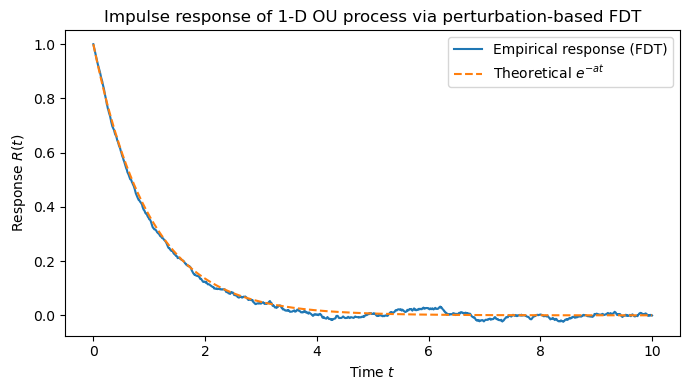

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the 1‑D Ornstein–Uhlenbeck (OU) process
a = 1.0          # relaxation rate
D = 1.0          # noise strength (diffusion coefficient)
delta = 1.0      # small perturbation applied at t = 0

# Simulation settings
dt = 0.01
t_max = 10.0
t = np.arange(0.0, t_max + dt, dt)
n_steps = t.size
ensemble_size = 10000  # large ensemble for smooth statistics

# Pre‑allocate arrays
x_unpert = np.zeros((ensemble_size, n_steps))
x_pert = np.zeros_like(x_unpert)

# Draw initial conditions from the equilibrium distribution N(0, D/a)
sigma_eq = np.sqrt(D / a)
x0 = np.random.normal(0.0, sigma_eq, size=ensemble_size)
x_unpert[:, 0] = x0
x_pert[:, 0] = x0 + delta  # apply an instantaneous perturbation

# Pre‑compute constants for the Euler–Maruyama scheme
sqrt_2Ddt = np.sqrt(2 * D * dt)

# Time‑march both ensembles
for n in range(1, n_steps):
    dW = np.random.normal(0.0, 1.0, size=ensemble_size)  # Brownian increments
    x_unpert[:, n] = x_unpert[:, n-1] + (-a * x_unpert[:, n-1]) * dt + sqrt_2Ddt * dW
    dW = np.random.normal(0.0, 1.0, size=ensemble_size)  # independent noise for perturbed ensemble
    x_pert[:, n] = x_pert[:, n-1] + (-a * x_pert[:, n-1]) * dt + sqrt_2Ddt * dW

# Compute the response function using the perturbation definition of the FDT
mean_diff = x_pert.mean(axis=0) - x_unpert.mean(axis=0)
R_empirical = mean_diff / delta

# Theoretical response function for comparison
R_theory = np.exp(-a * t)

# Plot the empirical and theoretical response functions
plt.figure(figsize=(7, 4))
plt.plot(t, R_empirical, label="Empirical response (FDT)")
plt.plot(t, R_theory, linestyle="--", label="Theoretical $e^{-a t}$")
plt.xlabel("Time $t$")
plt.ylabel("Response $R(t)$")
plt.title("Impulse response of 1‑D OU process via perturbation‑based FDT")
plt.legend()
plt.tight_layout()
plt.show()


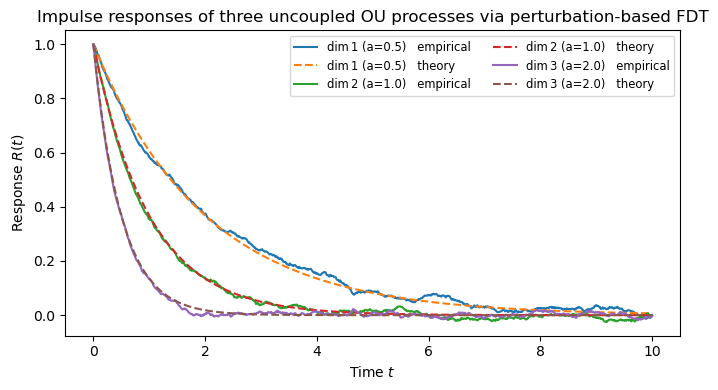

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters for three uncoupled 1‑D OU processes (x, y, z) -------------
a = np.array([0.5, 1.0, 2.0])  # relaxation rates for each dimension
D = 1.0                         # common diffusion coefficient
delta = 1.0                     # small perturbation applied at t = 0 to each coord
dim = 3

# --- Simulation settings ----------------------------------------------------
dt = 0.01
t_max = 10.0
t = np.arange(0.0, t_max + dt, dt)
n_steps = t.size
ensemble_size = 10000  # fewer members to keep memory reasonable in 3‑D

# --- Allocate state arrays: shape (ensemble, step, dim) ---------------------
x_unpert = np.zeros((ensemble_size, n_steps, dim))
x_pert   = np.zeros_like(x_unpert)

# --- Equilibrium initial distribution N(0, D/a) for each coord -------------
sigma_eq = np.sqrt(D / a)                  # shape (dim,)
x0 = np.random.normal(0.0, sigma_eq, size=(ensemble_size, dim))
x_unpert[:, 0, :] = x0
x_pert[:, 0, :]   = x0 + delta             # instantaneous perturbation Δx

# --- Pre‑compute constants for Euler–Maruyama -------------------------------
sqrt_2Ddt = np.sqrt(2 * D * dt)

# --- Time integration -------------------------------------------------------
for n in range(1, n_steps):
    dW = np.random.normal(0.0, 1.0, size=(ensemble_size, dim))
    x_unpert[:, n, :] = x_unpert[:, n-1, :] + (-a * x_unpert[:, n-1, :]) * dt + sqrt_2Ddt * dW
    
    dW = np.random.normal(0.0, 1.0, size=(ensemble_size, dim))
    x_pert[:, n, :] = x_pert[:, n-1, :] + (-a * x_pert[:, n-1, :]) * dt + sqrt_2Ddt * dW

# --- Empirical response: ⟨x_pert − x_unpert⟩ / Δx ---------------------------
mean_diff = x_pert.mean(axis=0) - x_unpert.mean(axis=0)   # shape (step, dim)
R_empirical = mean_diff / delta

# --- Theoretical responses for each dimension --------------------------------
R_theory = np.exp(-np.outer(t, a))  # shape (step, dim)

# --- Plot --------------------------------------------------------------------
plt.figure(figsize=(7, 4))
labels = ["dim 1 (a=0.5)", "dim 2 (a=1.0)", "dim 3 (a=2.0)"]
for k in range(dim):
    plt.plot(t, R_empirical[:, k], label=f"{labels[k]}   empirical")
    plt.plot(t, R_theory[:, k], linestyle="--", label=f"{labels[k]}   theory")

plt.xlabel("Time $t$")
plt.ylabel("Response $R(t)$")
plt.title("Impulse responses of three uncoupled OU processes via perturbation‑based FDT")
plt.legend(ncol=2, fontsize="small")
plt.tight_layout()
plt.show()


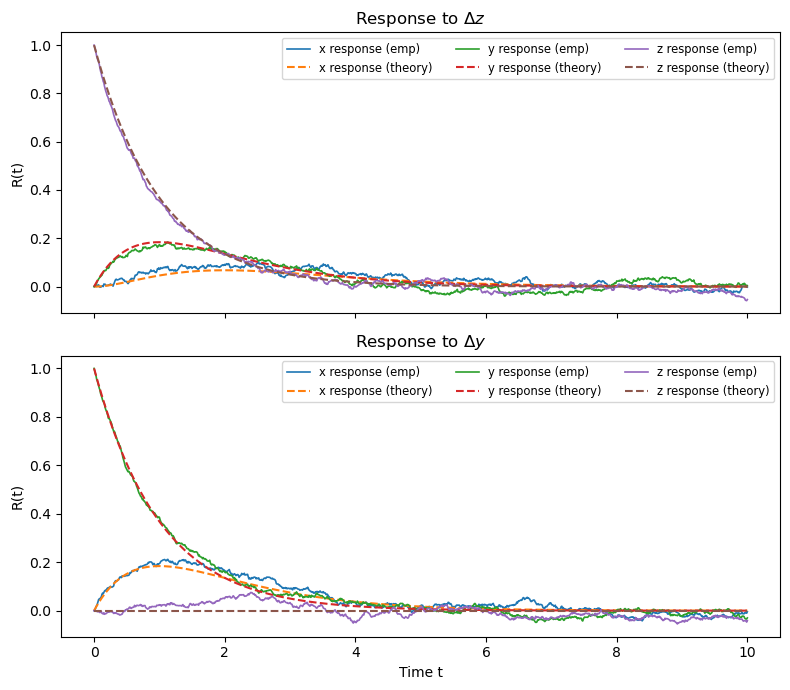

In [95]:
from scipy.linalg import expm

A = np.array([[-1.0,  0.5, 0.0],
              [ 0.0, -1.0, 0.5],
              [ 0.0,  0.0, -1.0]])

D = 1.0
delta = 1.0
dim = 3

dt = 0.01
t_max = 10.0
t = np.arange(0.0, t_max + dt, dt)
n_steps = t.size
ensemble_size = 20000

sqrt_2Ddt = np.sqrt(2 * D * dt)

mean_unpert = np.zeros((n_steps, dim))
mean_pz     = np.zeros_like(mean_unpert)     # perturbation in z
mean_py     = np.zeros_like(mean_unpert)     # perturbation in y


sigma_eq = np.sqrt(D / 1.0)
state_unpert = np.random.normal(0.0, sigma_eq, size=(ensemble_size, dim))
state_pz     = state_unpert.copy()
state_py     = state_unpert.copy()

state_pz[:, 2] += delta
state_py[:, 1] += delta

# ------------------ Store means at t = 0 -----------------------------------
mean_unpert[0] = state_unpert.mean(axis=0)
mean_pz[0]     = state_pz.mean(axis=0)
mean_py[0]     = state_py.mean(axis=0)

# Integrate
for n in range(1, n_steps):
    # Generate independent Gaussian increments for each ensemble
    dW_unpert = np.random.normal(0.0, 2.25, size=(ensemble_size, dim))
    dW_pz     = np.random.normal(0.0, 2.25, size=(ensemble_size, dim))
    dW_py     = np.random.normal(0.0, 2.25, size=(ensemble_size, dim))

    # Drift term: state @ A^T
    drift_unpert = state_unpert @ A.T
    drift_pz     = state_pz     @ A.T
    drift_py     = state_py     @ A.T

    # Euler–Maruyama update
    state_unpert += drift_unpert * dt + sqrt_2Ddt * dW_unpert
    state_pz     += drift_pz     * dt + sqrt_2Ddt * dW_pz
    state_py     += drift_py     * dt + sqrt_2Ddt * dW_py

    # Record ensemble means
    mean_unpert[n] = state_unpert.mean(axis=0)
    mean_pz[n]     = state_pz.mean(axis=0)
    mean_py[n]     = state_py.mean(axis=0)

# FDT
R_pz = (mean_pz - mean_unpert) / delta
R_py = (mean_py - mean_unpert) / delta

# Theoretical response
e_z = np.array([0.0, 0.0, 1.0])
e_y = np.array([0.0, 1.0, 0.0])

R_theory_z = np.array([expm(A * tau) @ e_z for tau in t])
R_theory_y = np.array([expm(A * tau) @ e_y for tau in t])

fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharex=True)

ax = axes[0]
ax.set_title(r"Response to $\Delta z$")
labels = ["x response", "y response", "z response"]
for k in range(dim):
    ax.plot(t, R_pz[:, k], label=f"{labels[k]} (emp)", linewidth=1.2)
    ax.plot(t, R_theory_z[:, k], linestyle="--", label=f"{labels[k]} (theory)")

ax.legend(fontsize="small", ncol=3)
ax.set_ylabel("R(t)")

ax = axes[1]
ax.set_title(r"Response to $\Delta y$")
for k in range(dim):
    ax.plot(t, R_py[:, k], label=f"{labels[k]} (emp)", linewidth=1.2)
    ax.plot(t, R_theory_y[:, k], linestyle="--", label=f"{labels[k]} (theory)")

ax.legend(fontsize="small", ncol=3)
ax.set_ylabel("R(t)")
ax.set_xlabel("Time t")

fig.tight_layout()
plt.show()


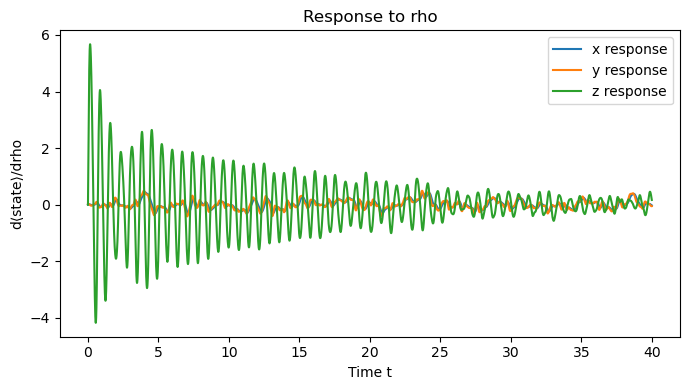

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Params
sigma, beta = 10.0, 8 / 3
rho_base = 28.0
dt = 0.005
delta_rho = 1.0/dt

D = 1.0
alpha = 1/1000
t_max = 40.0
t = np.arange(0.0, t_max + dt, dt)
n_steps = t.size
ensemble_size = 100000
sqrt_2Ddt = np.sqrt(2 * D * dt)

def lorenz(state, rho):
    x, y, z = state[:, 0], state[:, 1], state[:, 2]
    dx = sigma * (y - x)
    #dy = -(z + alpha*np.pow(z,3))*x + rho*x - y
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.stack([dx, dy, dz], axis=1)

# Spin up
state0 = np.random.normal(0.0, 5.0, size=(ensemble_size, 3))
warm_steps = 1000
for _ in range(warm_steps):
    dW = np.random.normal(0.0, 0.1, size=state0.shape)
    state0 += lorenz(state0, rho_base) * dt + sqrt_2Ddt * dW

# Baseline and perturbed ensembles share identical initial states
delta = 50*dt
state_base = state0.copy()
state_pert = state0.copy()
state_pert[:,1] += delta*state_base[:,0]

# Store means
mean_base = np.zeros((n_steps, 3))
mean_pert = np.zeros_like(mean_base)
mean_base[0] = state_base.mean(axis=0)
mean_pert[0] = state_pert.mean(axis=0)

# Integrate
t_check = 0
for n in range(1, n_steps):
    dW = np.random.normal(0.0, 0.1, size=state_base.shape)
    state_base += lorenz(state_base, rho_base) * dt + sqrt_2Ddt * dW
    #if t_check == 0:
    #    state_pert += lorenz(state_pert, rho_base + delta_rho) * dt + sqrt_2Ddt * dW
    #else:
    state_pert += lorenz(state_pert, rho_base) * dt + sqrt_2Ddt * dW

    mean_base[n] = state_base.mean(axis=0)
    mean_pert[n] = state_pert.mean(axis=0)
    t_check += dt

# FDT
R_rho = (mean_pert - mean_base) / delta
labels = ["x response", "y response", "z response"]

plt.figure(figsize=(7,4))
for k in range(3):
    plt.plot(t, R_rho[:, k], label=labels[k])

plt.title("Response to rho")
plt.xlabel("Time t")
plt.ylabel("d⟨state⟩/drho")
plt.legend()
plt.tight_layout()
plt.show()


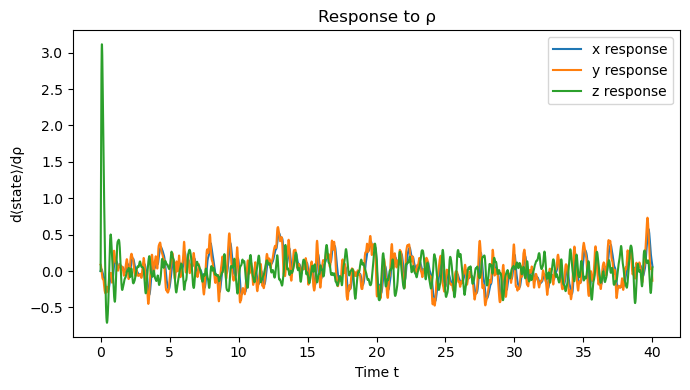

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# Parameters
sigma, beta  = 10.0, 8 / 3
rho_base     = 28.0
dt           = 0.01
delta_rho    = 1.0/dt
D            = 1.0
alpha        = 1/1000
t_max        = 40.0
t            = np.arange(0.0, t_max + dt, dt)
n_steps      = t.size
ensemble_size = 10000
eps = 5

# ----------------------------------------------------------------------
def lorenz(state, rho):
    """Vectorised Lorenz RHS for an ensemble of size (N, 3)."""
    x, y, z = state[:, 0], state[:, 1], state[:, 2]
    dx = sigma * (y - x)
    #dy = x * (rho - z) - y
    dy = -(z + alpha*np.pow(z,3))*x + rho*x - y
    dz = x * y - beta * z
    return np.stack([dx, dy, dz], axis=1)

def rk4_step(state, rho, dt):
    """Single classical RK4 step (vectorised over the ensemble)."""
    k1 = lorenz(state,                 rho)
    k2 = lorenz(state + 0.5*dt*k1,     rho)
    k3 = lorenz(state + 0.5*dt*k2,     rho)
    k4 = lorenz(state +       dt*k3,   rho)
    return state + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# ----------------------------------------------------------------------
# Spin-up
state0 = np.random.normal(0.0, 5.0, size=(ensemble_size, 3))
warm_steps = 5000
for _ in range(warm_steps):
    dW      = np.random.normal(0.0, 1, size=state0.shape)
    state0  = rk4_step(state0, rho_base, dt) + eps * np.sqrt(dt) * dW

# Baseline and perturbed ensembles share identical initial states
delta       = 50 * dt
state_base  = state0.copy()
state_pert  = state0.copy()
state_pert[:, 1] += delta * state_base[:, 0]

# Storage for means
mean_base = np.zeros((n_steps, 3))
mean_pert = np.zeros_like(mean_base)
mean_base[0] = state_base.mean(axis=0)
mean_pert[0] = state_pert.mean(axis=0)

# ----------------------------------------------------------------------
# Time integration
for n in range(1, n_steps):
    # identical noise for baseline & perturbed trajectories
    dW = np.random.normal(0.0, 1, size=state_base.shape)

    # RK4 deterministic advance + identical stochastic kick
    state_base = rk4_step(state_base, rho_base, dt) + eps * np.sqrt(dt) * dW
    state_pert = rk4_step(state_pert, rho_base, dt) + eps * np.sqrt(dt) * dW

    mean_base[n] = state_base.mean(axis=0)
    mean_pert[n] = state_pert.mean(axis=0)

# ----------------------------------------------------------------------
# FDT estimate of response
R_rho = (mean_pert - mean_base) / delta
labels = ["x response", "y response", "z response"]

plt.figure(figsize=(7, 4))
for k in range(3):
    plt.plot(t, R_rho[:, k], label=labels[k])

plt.title("Response to ρ")
plt.xlabel("Time t")
plt.ylabel("d⟨state⟩/dρ")
plt.legend()
plt.tight_layout()
plt.show()


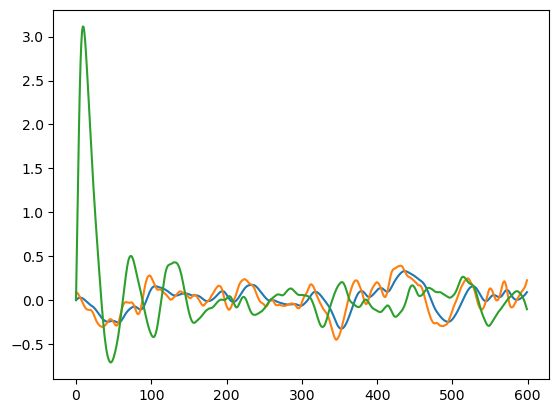

In [70]:
R_rho_cropped = R_rho[0:600]
plt.plot(R_rho_cropped)

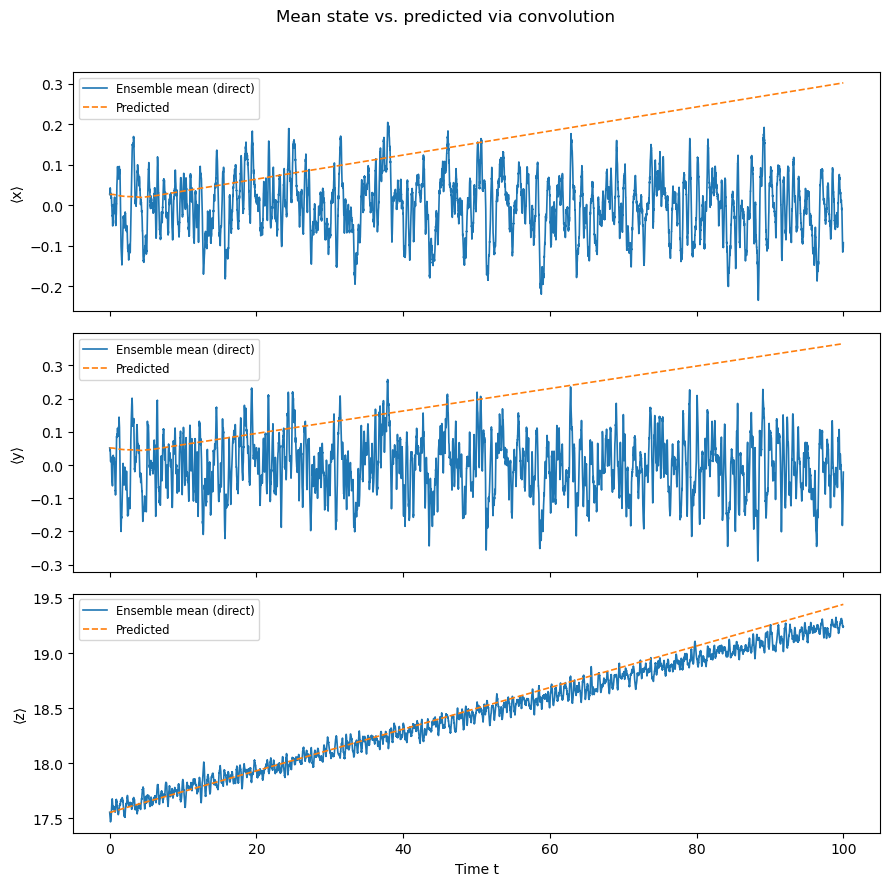

In [71]:
np.random.seed(0)

sigma, beta    = 10.0, 8/3
rho_base       = 28.0
delta_rho_imp  = 1.0
rho_start, rho_end = 28.0, 32.0
t_end          = 100.0
dt             = 0.01
t              = np.arange(0.0, t_end + dt, dt)
n_steps        = len(t)
ensemble_size  = 10000

# ----------------------------------------------------------------------
# Spin-up
state0 = np.random.normal(0.0, 5.0, size=(ensemble_size, 3))
warm_steps = 2000
for _ in range(warm_steps):
    dW      = np.random.normal(0.0, 1, size=state0.shape)
    state0  = rk4_step(state0, rho_base, dt) + eps * np.sqrt(dt) * dW

baseline_mean = state0.mean(axis=0)

rho_t = np.linspace(rho_start, rho_end, n_steps)
delta_rho_t = rho_t - rho_base

pred_anom = np.zeros((n_steps, 3))
for k in range(3):
    pred_anom[:, k] = np.convolve(delta_rho_t, R_rho_cropped[:, k], mode='full')[:n_steps] * dt

pred_mean = baseline_mean + pred_anom

state_var = state0.copy()
mean_var  = np.zeros((n_steps, 3))
mean_var[0] = state_var.mean(axis=0)

for n in range(1, n_steps):
    rho_now = rho_t[n-1]
    dW = np.random.normal(0.0, 1, size=state_var.shape)
    state_var = rk4_step(state_var, rho_now, dt) + eps * np.sqrt(dt) * dW
    mean_var[n] = state_var.mean(axis=0)


fig, axes = plt.subplots(3, 1, figsize=(9, 9), sharex=True)
var_labels = ['x', 'y', 'z']
for k, ax in enumerate(axes):
    ax.plot(t, mean_var[:, k], label='Ensemble mean (direct)', linewidth=1.2)
    ax.plot(t, pred_mean[:, k], '--', label='Predicted', linewidth=1.2)
    ax.set_ylabel(f'⟨{var_labels[k]}⟩')
    ax.legend(fontsize='small')

axes[-1].set_xlabel('Time t')
fig.suptitle('Mean state vs. predicted via convolution', y=0.98)
fig.tight_layout(rect=[0,0,1,0.96])
plt.show()
